### **1. Introduction & Roadmap**

**Where we’re coming from (NB02 in one line)**
In **NB02**, we framed forecasting as **one-step ahead**:
$$
X_t = [T_{t-S+1}, \dots, T_t] \;\longrightarrow\; \hat T_{t+1},
$$
with a window length $S=7$ (7 days of history), using **batch-first** tensors $(B,S,1)$ and small CPU-friendly models (RNN/LSTM/GRU).

**What we’re doing **today**
We extend the task to **multi-step forecasting**: given the same 7-day window, we want the **next $H$** days:
$$
X_t \;\longrightarrow\; \hat{\mathbf{y}}_t
= [\hat T_{t+1}, \hat T_{t+2}, \dots, \hat T_{t+H}] \in \mathbb{R}^{H}.
$$

- We will **keep shapes student-friendly**: inputs $(B,S,1)$, outputs:
  - **Recursive strategy:** produce $H$ scalars step by step, then stack to $(B,H)$ for evaluation.
  - **Direct strategy:** predict all $H$ values **at once** as a vector $(B,H)$.

What we’ll **compare**
1) **Recursive (autoregressive) rollout**  
   We **reuse our NB02 single-step models** $f$. Starting from the last $S$ truths, we predict $\hat T_{t+1}$, then **append our own prediction** to the window, slide, and predict $\hat T_{t+2}$, and so on up to $H$ steps.

2) **Direct multi-output head**  
   We train a model $g$ whose readout maps the last hidden state to an $H$-dimensional vector (one shot). This avoids step-by-step feedback of our own predictions.

> We will **not** decide which one is “best” in theory; we’ll let **data + metrics** (per-horizon MAE/RMSE) guide us.

What we’ll **reuse** vs **rebuild**
- **Reuse (from NB02):**
  - The **model classes** (RNN/LSTM/GRU) and, if available, the **saved weights** (`state_dict` files) in `./artifacts/`.
  - Our **batch-first** convention $(B,S,1)$ and small hidden sizes.

- **Rebuild (in this notebook):**
  - **Data pipeline** end-to-end: load CSV → **time-aware split** (train 1981–1988, test 1989–1990) → **scaler** fit on **train only** → transform train/test.
  - **Multi-step targets** (windows $\rightarrow$ vectors of length $H$) for evaluation.
  - A **Direct** model (e.g., GRU-Direct) trained briefly on CPU.

**Constraints (so our runs stay fast and reproducible)**
- **CPU-only** execution (no GPU assumptions).  
- **Short runs**: modest epochs (e.g., 15–25), small **hidden size** (e.g., 64), batch-first $(B,S,1)$.  
- **Deterministic seeds** where possible.  
- **No leakage**: we split by **time first**, then **fit scaler on train** only.

**How we’ll evaluate (high-level plan)**
- We’ll compute **MAE/RMSE per horizon** $k=1,\dots,H$ **in °C** (by inverse-transforming with the same train-fitted scaler).  
- We’ll include **simple baselines** (persistence, 7-day mean) to anchor difficulty.  
- We’ll **plot error vs horizon** and inspect a few **actual vs forecast** slices (steady vs turning segments).

**Roadmap for NB03 (what’s coming next)**
1. **Data loading + split + scaling** (self-contained refresh).  
2. **Framing & builders** for multi-step windows/targets (no leakage across the split).  
3. **Baselines** (persistence, 7-day mean) per horizon.  
4. **Recursive** rollout using NB02 models (RNN/LSTM/GRU).  
5. **Direct** multi-output model (e.g., GRU-Direct) with quick training.  
6. **Side-by-side** comparison + quick error analysis.  
7. **Save minimal artifacts** (best model weights) and wrap up.

**Reflection (think before we code)**
- Why do multi-step errors usually **grow with horizon** $k$?  
  *Hint:* in **Recursive**, early mistakes are **fed back** into the input (compounding). In **Direct**, later horizons are inherently **harder** (further from observed context).  
- Given our daily temperatures and $S=7$, where do we expect the **largest misses**—at **peaks**, **troughs**, or **transition** periods? Why?


### 🧭 What to notice in the sanity check
- **Shapes** match our convention: we fed a window shaped as $(1, S, 1)$, and each model returned $(1, 1)$.  
- The **predictions are in °C** after inverse scaling (we trained on scaled values, but we **always report** in degrees for interpretation).  
- If weights were **not found**, we see a warning—this is fine for now; we’ll still be able to demonstrate the **recursive** and **direct** strategies (and we can re-train quickly if needed).

In the next section, we will **frame the multi-step problem** carefully (recursive vs direct), and then we’ll **prepare the data** for multi-step targets.

---

### **2. Data Loading, Time Split, and Scaling (self-contained)**

**What we’ll do in this section**
We will set up **the full data pipeline** that the rest of NB03 depends on:

1) **Load** the CSV, parse dates **strictly**, and use the date as the index.  
2) Make a **time-aware split** → **train: 1981–1988**, **test: 1989–1990**.  
3) **Fit the scaler on train only** (to avoid leakage) and **transform** both train/test.  
4) Keep our **batch-first** convention for sequences: inputs shaped as $(B, S, 1)$ with defaults **$S=7$**, **$H=7$**.

> Why “fit on train only”?  
> Because the scaler learns parameters (for MinMax: **min** and **max**). If we fit it on the **entire dataset**, those parameters would “peek” at the future test years — a subtle but real **data leakage** that can inflate our reported accuracy. Instead, we **fit on train**, then **apply** to test.

We will also print **head/tail**, **date ranges**, and **scaled ranges** to sanity-check everything.

**Shapes we will use
- Raw series: a single column **Temp** indexed by dates.  
- After scaling, we will later reshape to **batch-first** $(B, S, 1)$ when we build windows.  
- Defaults for this notebook: **$S=7$** (history days), **$H=7$** (forecast days).

> Note: After fitting MinMax on train, **test values can map outside** $[0,1]$ (e.g., slightly negative or above 1) if test contains temperatures outside the train’s range. That’s **okay** and **not leakage** — it simply reflects distribution shift across years.

In [1]:
# --- Imports and simple config (self-contained) ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Default window/horizon for NB03 (we may change later in experiments)
S = 7   # history window length
H = 7   # forecast horizon

DATA_PATH = "dataset/1_Daily_minimum_temps.csv"

print(f"[NB03] Defaults -> S={S}, H={H}")


[NB03] Defaults -> S=7, H=7


In [2]:
# --- Load CSV with strict date parsing and clean numeric Temp ---
# The file uses MM/DD/YY format (e.g., 01/13/81 = Jan 13, 1981).
df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y")  # strict format (no guessing)
df["Temp"] = pd.to_numeric(df["Temp"], errors="coerce")     # coerce any bad records to NaN
df = df.dropna(subset=["Temp"]).set_index("Date").sort_index()

print("Shape (rows, cols):", df.shape)
display(df.head(5))
display(df.tail(5))

# Optional sanity checks
is_monotonic = df.index.is_monotonic_increasing
print("Date index monotonic increasing? ->", is_monotonic)

# Count missing days (we are not resampling here; just a quick heads-up)
expected_days = (df.index.max() - df.index.min()).days + 1
missing_days = expected_days - len(df)
print(f"Rough missing-day check: expected ~{expected_days}, actual {len(df)}, missing ~{missing_days}")


Shape (rows, cols): (3647, 1)


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


Date index monotonic increasing? -> True
Rough missing-day check: expected ~3652, actual 3647, missing ~5


In [3]:
# --- Time-aware split: Train (1981–1988) vs Test (1989–1990) ---
split_date = pd.Timestamp("1989-01-01")  # test starts here

df_train = df.loc[: split_date - pd.Timedelta(days=1)]
df_test  = df.loc[split_date :]

print(f"Train range: {df_train.index.min().date()} → {df_train.index.max().date()} | rows={len(df_train)}")
print(f" Test range: {df_test.index.min().date()}  → {df_test.index.max().date()}  | rows={len(df_test)}")


Train range: 1981-01-01 → 1988-12-30 | rows=2917
 Test range: 1989-01-01  → 1990-12-31  | rows=730


In [4]:
# --- Fit MinMaxScaler on TRAIN ONLY (no leakage), then transform both splits ---
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on train values only
scaler.fit(df_train[["Temp"]])

# Transform to numpy arrays (N, 1)
train_scaled = scaler.transform(df_train[["Temp"]])
test_scaled  = scaler.transform(df_test[["Temp"]])

print("Scaled range (TRAIN) min/max:", float(train_scaled.min()), float(train_scaled.max()))
print("Scaled range (TEST)  min/max:", float(test_scaled.min()),  float(test_scaled.max()))


Scaled range (TRAIN) min/max: 0.0 1.0
Scaled range (TEST)  min/max: 0.019011406844106463 0.8403041825095058


**✅ Quick checklist (did we get this right?)**
- We **parsed dates strictly** and set the date as the index.  
- We **split by time** first, then **fit the scaler on train** and **applied** it to test.  
- We saw the **train scaled** values span (almost exactly) $[0,1]$.  
- We saw **test scaled** values may be slightly outside $[0,1]$ — that’s expected and **not leakage**.

> From here, we will construct **sliding windows** later as **batch-first** tensors, $(B, S, 1)$, and build multi-step targets of length $H$.

**Reflection**
- Why is it important that we **fit the scaler on train only** and **not** on the entire dataset?  
  *Think:* the scaler’s parameters (min/max) would otherwise be influenced by **future** data. That is a subtle form of **cheating** (data leakage) that can make our models look better than they truly are when deployed.  
- Why is it okay that **test scaled** values sometimes go outside $[0,1]$?  
  *Because the scaler learned its min/max from **train**. If the test period is hotter/colder than anything in train, the scaled values reflect that shift — which is exactly what we want the model to learn to handle.*

---

### **3. Framing Multi-Step Forecasting (intuition + math + builders)**

**From one-step to multi-step (what changes and why)**
In NB02 we did **one-step** forecasting:
$$
X_t = [T_{t-S+1}, \dots, T_t] \;\longrightarrow\; \hat T_{t+1}.
$$

In NB03 we want a **vector** of the next \(H\) days:
$$
X_t \;\longrightarrow\; \hat{\mathbf{y}}_t
= [\hat T_{t+1}, \hat T_{t+2}, \dots, \hat T_{t+H}] \in \mathbb{R}^{H}.
$$

We will compare two families of approaches: **Recursive** (a.k.a. autoregressive rollout) and **Direct** (multi-output head). Below we explain both in **plain words**, with **equations**, **diagrams**, and a **tiny numeric example** so we can internalize what each does.

>**Strategy A — Recursive rollout (reuse our NB02 one-step model)**

**Idea in words.**  
We take our single-step model \(f\) (from NB02). We use it to predict **tomorrow** from today’s \(S\)-day window. Then we **append our own prediction** to the window, drop the oldest value, and ask the same model to predict **the day after tomorrow**. We repeat this \(H\) times to get \(H\) steps ahead.

**Equations.**
$$
\begin{aligned}
\hat T_{t+1} &= f([T_{t-S+1},\dots,T_t]), \\
\hat T_{t+2} &= f([T_{t-S+2},\dots,T_t, \hat T_{t+1}]), \\
&\ \vdots \\
\hat T_{t+k} &= f([\text{last }(S-1)\text{ truths/preds},\ \hat T_{t+k-1}]) \quad \text{for } k=1,\dots,H.
\end{aligned}
$$

**ASCII diagram (batch-first shapes):**

Input $X_t$ (B, S, 1) ──► sequence encoder ──► $h_{last}$ ──► Linear(hidden, H) ──► [$ŷ_{t+1}$..$ŷ_{t+H}$] (B, H)

- **$X_t$**: input sequence of $S$ timesteps for each of $B$ samples.
- **`sequence encoder`**: RNN/LSTM/GRU or Transformer encoder.
- **$h_{\text{last}}$**: last hidden state (e.g. from final timestep).
- **`Linear(hidden, H)`**: fully connected layer mapping to $H$ outputs.
- **Output**: $\hat{\mathbf{y}} \in \mathbb{R}^{B \times H}$ — forecasts for next $H$ steps.


**Why it can help: avoids step-by-step drift.**  
Because we **do not feed predictions back** into the input during inference, there is **no compounding** from step to step. The model can also learn **different behaviors per horizon** (e.g., be more conservative for long $k$) because it predicts all $H$ together.

**Why it can be harder: “bigger head” + harder supervision.**
- **Bigger head = more parameters**: the readout is $\text{Linear}(\text{hidden}\rightarrow H)$, which has $H$ outputs instead of one; this slightly increases capacity and risk of overfitting on small data.
- **Coupled targets**: the $H$ outputs are **correlated** (tomorrow and the day after are related). The model must learn a **joint mapping** that keeps the vector **consistent** across horizons. We’ll train with an average MSE over the $H$ outputs:
  $$
  \mathcal{L}_{\text{direct}} = \frac{1}{H} \sum_{k=1}^{H} \left( \hat T_{t+k} - T_{t+k} \right)^2.
  $$

**When direct shines.**
- We care about **stable long-horizon** forecasts and want to **avoid drift**.
- We can afford to (re)train a small head with **CPU-friendly** epochs.

**📐 Shape convention we’ll keep using**
- **Inputs** (windows): $(B, S, 1)$ — batch-first, one feature (temperature).  
- **Outputs (direct)**: $(B, H)$.  
- **Outputs (recursive)**: we generate $H$ scalars over steps and then **stack** → $(B, H)$ for evaluation.

**🔧 Builder — from a series to $(X, y)$ windows (with **no leakage**)**

We must turn a **univariate series** (scaled) into **overlapping** windows $X$ and vector targets $y$:

- For each index $i$ such that we have **$S$ days of history** and **$H$ days ahead**:
  - Window $X_i = [v_{i-S}, \dots, v_{i-1}] \in \mathbb{R}^{S\times 1}$  
  - Target $y_i = [v_i, v_{i+1}, \dots, v_{i+H-1}] \in \mathbb{R}^{H}$

We **must** build windows **separately** on **train** and **test** splits:

- If we built on the whole series and then split, some windows near the boundary would **cross** from train into test (or vice versa). That would leak **future info** into the train set or **contaminate evaluation** on the test set.  
- By building **per split**, every train window contains **only train-period** values, and every test window contains **only test-period** values.

**Edge case:** if we are near the **end** of a split and there aren’t enough days to fill the \(H\)-step target, we **drop** that window. This keeps dimensions consistent and avoids peeking outside the split.

**Visual timeline (train split example):**

... $T_{i-S}\ T_{i-S+1}\ \dots\ T_{i-1}$ $\mid$ $T_i\ T_{i+1}\ \dots\ T_{i+H-1}$ ...

<----------- $S$ ------------>     <----------- $H$ ----------->

**$X$ window (history)**  ------|------     **$y$ vector (targets)**


In [5]:
# --- Multi-step sequence builder (build TRAIN and TEST *separately*) ---
import numpy as np

def create_multi_step_sequences(values, S=7, H=7):
    """
    Convert a 1D series (scaled) into overlapping windows X and vector targets y.

    Args
    ----
    values : np.ndarray of shape (N,) or (N,1)
        Scaled temperature values for *one* split (train OR test).
    S : int
        Window length (# history steps).
    H : int
        Forecast horizon (# future steps).

    Returns
    -------
    X : np.ndarray, shape (N_samples, S, 1)
        Each sample is a window of length S (last dimension is the feature=1).
    y : np.ndarray, shape (N_samples, H)
        Each sample is a vector of H consecutive future values.

    Notes
    -----
    - We only generate windows that have a *full* H-step target.
    - If the series is too short for (S, H), we return empty arrays.
    - This function does *not* cross split boundaries because we call it
      separately on train_scaled and test_scaled.
    """
    v = values.reshape(-1)  # ensure 1D
    N = len(v)
    X_list, y_list = [], []
    # i = index of the first target value (T_{t+1} in our earlier notation)
    for i in range(S, N - H + 1):
        x_win = v[i - S : i]   # S values ending at i-1
        y_vec = v[i : i + H]   # H future values starting at i
        X_list.append(x_win[:, None])   # (S, 1)
        y_list.append(y_vec)            # (H,)
    if not X_list:
        return (np.empty((0, S, 1), dtype=np.float32),
                np.empty((0, H),    dtype=np.float32))
    X = np.stack(X_list).astype(np.float32)  # (N_samples, S, 1)
    y = np.stack(y_list).astype(np.float32)  # (N_samples, H)
    return X, y

# Build train/test sequences separately (no boundary crossing)
X_train, y_train = create_multi_step_sequences(train_scaled, S=S, H=H)
X_test,  y_test  = create_multi_step_sequences(test_scaled,  S=S, H=H)

print("Train X shape:", X_train.shape, "| y shape:", y_train.shape)
print(" Test X shape:", X_test.shape,  "| y shape:",  y_test.shape)


Train X shape: (2904, 7, 1) | y shape: (2904, 7)
 Test X shape: (717, 7, 1) | y shape: (717, 7)


In [6]:
# --- Tiny preview (2–3 rows) converted back to °C for human readability ---
import pandas as pd

def preview_sequences(df_split, scaled_split, X, y, scaler, S=7, H=7, n=3):
    """
    Show 'n' samples: window end date, last 3 values of the window (°C),
    first 3 target dates/values (°C), so we can verify alignment.
    Assumes df_split.index aligns with scaled_split row-by-row.
    """
    rows = min(n, len(X))
    out = []
    for r in range(rows):
        # Window X[r] corresponds to indices [r .. r+S-1] in the split
        start_idx = r
        end_idx   = r + S - 1
        target_start = end_idx + 1
        window_dates = df_split.index[start_idx : end_idx + 1]
        target_dates = df_split.index[target_start : target_start + H]

        # Back to °C
        xC = scaler.inverse_transform(X[r].reshape(S, 1)).reshape(-1)
        yC = scaler.inverse_transform(y[r].reshape(H, 1)).reshape(-1)

        out.append({
            "window_end": str(window_dates[-1].date()),
            "window_tail_C (last 3)": [round(x, 1) for x in xC[-3:]],
            "target_dates (first 3)": [str(d.date()) for d in target_dates[:3]],
            "target_C (first 3)": [round(v, 1) for v in yC[:3]],
        })
    return pd.DataFrame(out)

print("── Train preview ──")
display(preview_sequences(df_train, train_scaled, X_train, y_train, scaler, S=S, H=H, n=3))

print("── Test preview ──")
display(preview_sequences(df_test,  test_scaled,  X_test,  y_test,  scaler, S=S, H=H, n=3))


── Train preview ──


,window_end,window_tail_C (last 3),target_dates (first 3),target_C (first 3)
0,1981-01-07,"[15.8, 15.8, 15.8]","[1981-01-08, 1981-01-09, 1981-01-10]","[17.4, 21.8, 20.0]"
1,1981-01-08,"[15.8, 15.8, 17.4]","[1981-01-09, 1981-01-10, 1981-01-11]","[21.8, 20.0, 16.2]"
2,1981-01-09,"[15.8, 17.4, 21.8]","[1981-01-10, 1981-01-11, 1981-01-12]","[20.0, 16.2, 13.3]"


── Test preview ──


,window_end,window_tail_C (last 3),target_dates (first 3),target_C (first 3)
0,1989-01-07,"[11.5, 9.5, 12.2]","[1989-01-08, 1989-01-09, 1989-01-10]","[15.7, 16.3, 13.6]"
1,1989-01-08,"[9.5, 12.2, 15.7]","[1989-01-09, 1989-01-10, 1989-01-11]","[16.3, 13.6, 12.6]"
2,1989-01-09,"[12.2, 15.7, 16.3]","[1989-01-10, 1989-01-11, 1989-01-12]","[13.6, 12.6, 13.8]"


**✅ What we just verified**
- Our builder returns windows $X$ shaped $(N_{\text{samples}}, S, 1)$ and vector targets $y$ shaped $(N_{\text{samples}}, H)$ — **ready for batch-first models**.  
- The preview confirms that each window’s **end date** is immediately followed by its **target dates**, and the values look sensible in **°C**.

**💬 Reflection (slow thinking)**
- **Why do we build train and test windows separately?**  
  Because any window that stretches across the split would **peek at the future** (leakage). We want train windows that contain only **train-period** values, and test windows that contain only **test-period** values.  
- **Why might recursive methods show growing MAE@$k$?**  
  Because after step 1, we feed **our own predictions** back in (not ground truth). Any small miss at $k{=}1$ becomes part of the input for $k{=}2$, and so on — this is **compounding error** caused by **exposure bias** (the mismatch between training on truths and inferring on our own outputs).  
- **Why might direct methods still struggle at long $k$?**  
  Later horizons are **farther** from observed context, and the model must get **all $H$** outputs right **together**. That’s a **harder supervision** problem with a **bigger readout**; it needs careful training (but it avoids drift).

---

### **4. Baselines for $H$-step Forecasting (yardsticks first)**

Before we compare any deep models, we set **simple, transparent yardsticks**. These baselines tell us whether a learned model is actually adding value over very strong short-horizon heuristics.

**🪄 Two classical baselines**

1) **Persistence (a.k.a. last-value)**
The forecast for all next \(H\) days is simply **today’s value**:
$$
\hat T_{t+k} = T_t \quad \text{for } k=1,\dots,H.
$$

**Why this can be strong:** daily minimum temperatures are **highly autocorrelated** from one day to the next, especially over short horizons. If the signal changes slowly, “tomorrow \(\approx\) today” does surprisingly well.

2) **7-day mean (local average)**
We predict the next \(H\) days using the **average of the last 7 days**:
$$
\hat T_{t+k} \;=\; \frac{1}{7}\sum_{j=0}^{6} T_{t-j}
\quad \text{for } k=1,\dots,H.
$$

**Why this can be strong:** the local mean **smooths noise** and tracks the **short-term level** of the series. That can beat many small models on short horizons, especially when the series is smooth or slowly drifting.

**How we’ll evaluate baselines (fairly)**
- We will compute **MAE** and **RMSE** **by horizon** \(k=1,\dots,H\).
- We’ll build baselines **from the same input windows** we built for the models (Section 3), so comparisons are apples-to-apples.
- Baselines are computed in **scaled space** for convenience but all **metrics are reported in °C** after **inverse scaling** with the **train-fitted** scaler.

> If a learned model cannot beat **Persistence** or the **7-day mean**, we should **not** jump to more complex architectures. We should first revisit our **framing** (window size \(S\)), **features** (e.g., seasonal signals), and **training setup**.

**📈 What to look for in the curves**
- **MAE@1** is usually the smallest (nearest horizon), and errors **increase** as \(k\) grows.  
- If **Persistence** wins at very short horizons and **7-day mean** wins at slightly longer horizons, that’s a signature of **smooth, slowly changing** series.
- If your learned model does **not** beat at least one baseline for most \(k\), that’s a strong hint to **rethink the setup** (see Reflection below).

In [ ]:
# --- Baseline metrics by horizon (in °C) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def inverse_to_celsius(arr_scaled, scaler):
    """Inverse-transform scaled array to °C. Supports shapes (N,), (N,1), or (N,H)."""
    arr = np.asarray(arr_scaled)
    if arr.ndim == 1:
        arr2 = arr.reshape(-1, 1)
        out = scaler.inverse_transform(arr2).reshape(-1)
    elif arr.ndim == 2:
        out = np.zeros_like(arr, dtype=float)
        # inverse transform column-wise
        for j in range(arr.shape[1]):
            col = arr[:, j].reshape(-1, 1)
            out[:, j] = scaler.inverse_transform(col).reshape(-1)
    else:
        raise ValueError("Expected 1D or 2D array for inverse_to_celsius.")
    return out

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def baseline_persistence(X_windows, H):
    """
    X_windows: (N, S, 1) scaled
    Return preds_pers: (N, H) scaled, where each horizon uses last value of window.
    """
    last_vals = X_windows[:, -1, 0]              # (N,)
    preds = np.tile(last_vals[:, None], (1, H))  # repeat across horizon -> (N, H)
    return preds

def baseline_7day_mean(X_windows, H):
    """
    X_windows: (N, S, 1) scaled
    Return preds_mean7: (N, H) scaled, where each horizon uses the 7-day mean.
    Assumes S >= 7 (we set S=7 by default in this notebook).
    """
    # average across the last S=7 values
    means = X_windows[:, -7:, 0].mean(axis=1)    # (N,)
    preds = np.tile(means[:, None], (1, H))      # (N, H)
    return preds

def horizon_metrics_by_model(y_true_scaled, y_pred_scaled, scaler):
    """
    Compute MAE@k and RMSE@k (in °C) for k=1..H, plus overall means.
    y_*_scaled: (N, H) arrays in scaled space.
    """
    # inverse-transform to °C
    y_true_C = inverse_to_celsius(y_true_scaled, scaler)  # (N, H)
    y_pred_C = inverse_to_celsius(y_pred_scaled, scaler)  # (N, H)

    H = y_true_C.shape[1]
    rows = []
    for k in range(H):
        mae_k  = mae(y_true_C[:, k], y_pred_C[:, k])
        rmse_k = rmse(y_true_C[:, k], y_pred_C[:, k])
        rows.append({"horizon_k": k+1, "MAE_C": mae_k, "RMSE_C": rmse_k})
    df = pd.DataFrame(rows)
    df.loc["mean"] = {"horizon_k": "mean",
                      "MAE_C": df["MAE_C"].mean(),
                      "RMSE_C": df["RMSE_C"].mean()}
    return df, y_true_C, y_pred_C

# Compute baseline predictions (scaled space)
pred_pers_scaled  = baseline_persistence(X_test, H=H)     # (N_test, H)
pred_mean7_scaled = baseline_7day_mean(X_test,  H=H)      # (N_test, H)

# Metrics per horizon (°C)
df_pers,  yC_test, yC_pers  = horizon_metrics_by_model(y_test, pred_pers_scaled,  scaler)
df_mean7, _,       yC_mean7 = horizon_metrics_by_model(y_test, pred_mean7_scaled, scaler)

print("Persistence baseline (per-horizon) — MAE/RMSE in °C:")
display(df_pers)

print("7-day mean baseline (per-horizon) — MAE/RMSE in °C:")
display(df_mean7)

Persistence baseline (per-horizon) — MAE/RMSE in °C:


,horizon_k,MAE_C,RMSE_C
0,1,1.954951,2.484089
1,2,2.525244,3.212458
2,3,2.704742,3.430203
3,4,2.747699,3.464200
4,5,2.805858,3.489034
5,6,2.816876,3.499721
6,7,2.751464,3.485699
mean,mean,2.615262,3.295058


7-day mean baseline (per-horizon) — MAE/RMSE in °C:


,horizon_k,MAE_C,RMSE_C
0,1,2.038275,2.591313
1,2,2.161227,2.762087
2,3,2.220383,2.823961
3,4,2.252461,2.862868
4,5,2.285555,2.893421
5,6,2.299203,2.910750
6,7,2.300020,2.917210
mean,mean,2.222446,2.823087


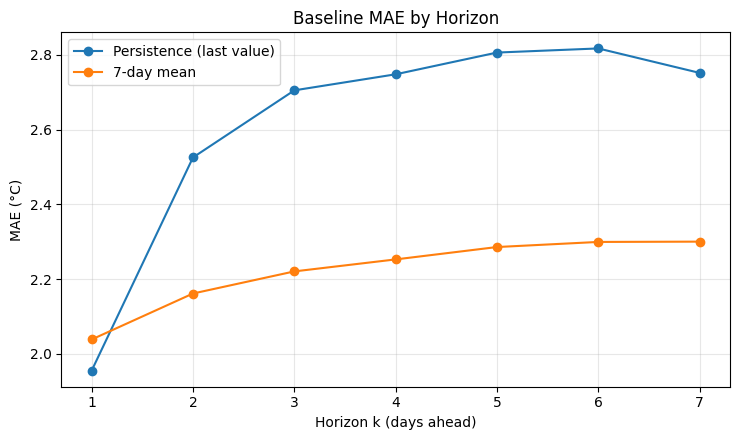

In [8]:
# --- Plot MAE vs horizon for both baselines ---
plt.figure(figsize=(7.5, 4.5))
plt.plot(df_pers.loc[df_pers.index != "mean", "horizon_k"],  # exclude the 'mean' row
         df_pers.loc[df_pers.index != "mean", "MAE_C"],
         marker="o", label="Persistence (last value)")
plt.plot(df_mean7.loc[df_mean7.index != "mean", "horizon_k"],
         df_mean7.loc[df_mean7.index != "mean", "MAE_C"],
         marker="o", label="7-day mean")

plt.xlabel("Horizon k (days ahead)")
plt.ylabel("MAE (°C)")
plt.title("Baseline MAE by Horizon")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**Interpreting the baseline curves (what the plot is telling us)**

We see two very different behaviors. **Persistence** is excellent for the **first step**: at $k=1$ it has the lowest MAE, which matches our intuition that “tomorrow ≈ today” for daily minimum temperatures. But as soon as we look further ahead, its error **climbs quickly**. This happens because persistence carries **one specific value** (today’s) forward no matter what; if the series is trending or about to turn, that single value becomes a **biased anchor**, so the forecast **lags** behind reality more and more with each additional day.

In contrast, the **7-day mean** starts a little worse than persistence at $k=1$ (averaging dulls sharp day-to-day details), but its error grows **slowly** and then **plateaus**. The mean captures the **local level** of the series—essentially the short-term seasonal baseline—so even though it misses bumps and dips on any single day, it stays **well-calibrated** across several days. That’s why from $k\ge 2$ the 7-day mean is **consistently better** than persistence.

**Takeaways for our models.**  
If we want to beat these baselines:

- For **very short horizons** ($k=1$), our model must capture **high autocorrelation**—it should at least match persistence.  
- For **multi-day horizons**, we need the model to understand the **local level** (like the 7-day mean does) *and* adapt to **directional changes** (where persistence fails). This is where sequence models can win: they can combine recent level + momentum and reduce **phase lag**.  
- If our learned curves sit **above** the orange line (7-day mean) for most $k$, we should revisit window size $S$, add **seasonal signals** (e.g., day-of-year $\sin/\cos$), or consider the **Direct** strategy to avoid step-by-step drift.

In short, the plot sets a clear bar: **match or beat persistence at $k=1$** and **beat the 7-day mean for $k\ge 2$**—otherwise, we’re not exploiting what sequence models can learn beyond simple heuristics.

---

### **5 — Strategy A: **Recursive** Rollout (reuse NB02 single-step)**

**🧭 What we’re doing**
We will **reuse the single-step forecasters** we built in NB02 (RNN / LSTM / GRU).  
Given a test window $X_t=[T_{t-S+1},\dots,T_t]$, we will:

1) Predict **tomorrow** $\hat T_{t+1}$ with our one-step model $f$.  
2) **Append** $\hat T_{t+1}$ to the window, **drop** the oldest value → new window.  
3) Predict **day $t{+}2$**, append, drop… and repeat until we produce all $H$ steps:
$$
\hat T_{t+1}=f(X_t),\quad
\hat T_{t+2}=f([T_{t-S+2},\dots,T_t,\hat T_{t+1}]),\ \dots,\ 
\hat T_{t+H}=f(\ldots,\hat T_{t+H-1}).
$$

We will do this **in scaled space** (because models were trained on scaled values), and only **inverse-transform to °C** for metrics and plots.

**🔍 Why this approach can drift**
- **Exposure bias (train vs. inference mismatch).** During training in NB02, the model always saw **true** histories. During recursive inference, after the first step the window **contains our own prediction**, not the truth. If the first step is slightly off, the next input is slightly wrong, which nudges the **second** prediction, and so on.
- **Compounding error.** Because each prediction **feeds** the next, small early errors can **accumulate** across the horizon. Typical symptoms: a **lag** on peaks/troughs, and **growing MAE/RMSE** with horizon $k$.

> This strategy is still great when $H$ is **short** and the series is **smooth**. Our goal is to measure how quickly the error grows and compare it to the baselines from Section 4.

**🏗️ What we will implement**
- A safe loader for NB02 weights (`./artifacts/*_state.pkl`). If a file is missing, we’ll continue with random-initialized weights (and we’ll note that in the output).
- `rollout_recursive(model, X_windows, H)` that produces predictions of shape $(N, H)$ for all test windows $(N,S,1)$.
- Horizon-wise **MAE/RMSE in °C**; we’ll **overlay** the curves with our **baselines** (persistence & 7-day mean).
- One “**actual vs predicted**” plot for **horizon $k{=}1$** over the **first 200** test samples to visualize drift/lag.

In [11]:
# --- Safety: ensure we have the models from Section 1 (or recreate + try to load weights) ---
import os, torch, torch.nn as nn

try:
    model_rnn, model_lstm, model_gru
except NameError:
    # Rebuild classes (same as NB02)
    class RNNModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
            super().__init__()
            self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                              num_layers=num_layers, nonlinearity="tanh",
                              batch_first=batch_first)
            self.head = nn.Linear(hidden_size, 1)
            self.hidden_size = hidden_size
            self.num_layers = num_layers

        def forward(self, x):
            B = x.size(0)
            h0 = x.new_zeros(self.num_layers, B, self.hidden_size)
            out, _ = self.rnn(x, h0)         # (B,S,H)
            y = self.head(out[:, -1, :])     # (B,1)
            return y

    class LSTMModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
            super().__init__()
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=batch_first)
            self.head = nn.Linear(hidden_size, 1)
            self.hidden_size = hidden_size
            self.num_layers = num_layers

        def forward(self, x):
            B = x.size(0)
            h0 = x.new_zeros(self.num_layers, B, self.hidden_size)
            c0 = x.new_zeros(self.num_layers, B, self.hidden_size)
            out, _ = self.lstm(x, (h0, c0))  # (B,S,H)
            y = self.head(out[:, -1, :])     # (B,1)
            return y

    class GRUModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
            super().__init__()
            self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=batch_first)
            self.head = nn.Linear(hidden_size, 1)
            self.hidden_size = hidden_size
            self.num_layers = num_layers

        def forward(self, x):
            B = x.size(0)
            h0 = x.new_zeros(self.num_layers, B, self.hidden_size)
            out, _ = self.gru(x, h0)         # (B,S,H)
            y = self.head(out[:, -1, :])     # (B,1)
            return y

    DEVICE = torch.device("cpu")
    ART_DIR = "artifacts"

    model_rnn  = RNNModel(batch_first=True).to(DEVICE)
    model_lstm = LSTMModel(batch_first=True).to(DEVICE)
    model_gru  = GRUModel(batch_first=True).to(DEVICE)

    def try_load(model, path):
        if os.path.exists(path):
            state = torch.load(path, map_location=DEVICE, weights_only=False)
            model.load_state_dict(state)
            print(f"✅ Loaded weights from: {path}")
        else:
            print(f"⚠️ Not found (using random init): {path}")

    try_load(model_rnn,  os.path.join(ART_DIR, "rnn_state.pkl"))
    try_load(model_lstm, os.path.join(ART_DIR, "lstm_state.pkl"))
    try_load(model_gru,  os.path.join(ART_DIR, "gru_state.pkl"))

model_rnn.eval(); model_lstm.eval(); model_gru.eval();


In [16]:
# 1) Strict weight loading (fail fast if missing/mismatched)
def load_or_fail(model, path, name="model"):
    if not os.path.exists(path):
        raise FileNotFoundError(f"❗ {name} weights not found at: {path} "
                                f"(train briefly in NB02 or skip this model).")
    state = torch.load(path, map_location=DEVICE)
    model.load_state_dict(state, strict=True)   # strict=True -> shape/key check
    print(f"✅ Loaded weights: {path}")

# Example calls (use same hyperparams as NB02!)
load_or_fail(model_rnn,  os.path.join(ART_DIR, "rnn_state.pkl"),  "RNN")
load_or_fail(model_lstm, os.path.join(ART_DIR, "lstm_state.pkl"), "LSTM")
load_or_fail(model_gru,  os.path.join(ART_DIR, "gru_state.pkl"),  "GRU")


✅ Loaded weights: artifacts\rnn_state.pkl
✅ Loaded weights: artifacts\lstm_state.pkl
✅ Loaded weights: artifacts\gru_state.pkl


C:\Users\noman\AppData\Local\Temp\ipykernel_24380\2484474137.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=DEVICE)


In [17]:
# 3) Safer recursive rollout in *scaled* space (with optional clamp guardrail)
@torch.no_grad()
def rollout_recursive(model, X_windows, H, clamp=True, lo=-0.2, hi=1.2):
    """
    X_windows: (N,S,1) *scaled*
    Returns: preds_scaled (N,H)
    """
    N, S, _ = X_windows.shape
    preds = np.zeros((N, H), dtype=np.float32)

    for i in range(N):
        buf = X_windows[i, :, 0].astype(np.float32)  # length S, scaled
        for k in range(H):
            xb = torch.tensor(buf, dtype=torch.float32).view(1, S, 1)
            yhat = float(model(xb).item())  # scaled
            if clamp:
                # demo guardrail: keep values near the trained range
                yhat = float(np.clip(yhat, lo, hi))
            preds[i, k] = yhat
            buf = np.concatenate([buf[1:], [yhat]])  # append pred in *scaled* space
    return preds


In [13]:
# --- Run recursive rollout for RNN/LSTM/GRU on the test set ---
pred_rnn_rec_scaled  = rollout_recursive(model_rnn,  X_test, H)
pred_lstm_rec_scaled = rollout_recursive(model_lstm, X_test, H)
pred_gru_rec_scaled  = rollout_recursive(model_gru,  X_test, H)

# Compute per-horizon metrics (°C) using helpers from Section 4
df_rnn_rec,  yC_test, yC_rnn_rec  = horizon_metrics_by_model(y_test, pred_rnn_rec_scaled,  scaler)
df_lstm_rec, _,       yC_lstm_rec = horizon_metrics_by_model(y_test, pred_lstm_rec_scaled, scaler)
df_gru_rec,  _,       yC_gru_rec  = horizon_metrics_by_model(y_test, pred_gru_rec_scaled,  scaler)

print("RNN (recursive) — per-horizon MAE/RMSE in °C")
display(df_rnn_rec)
print("LSTM (recursive) — per-horizon MAE/RMSE in °C")
display(df_lstm_rec)
print("GRU (recursive) — per-horizon MAE/RMSE in °C")
display(df_gru_rec)


RNN (recursive) — per-horizon MAE/RMSE in °C


,horizon_k,MAE_C,RMSE_C
0,1,1.777527,2.257531
1,2,2.116741,2.712523
2,3,2.201457,2.827798
3,4,2.249847,2.878662
4,5,2.302540,2.928766
5,6,2.333088,2.981778
6,7,2.364452,3.025984
mean,mean,2.192236,2.801863


LSTM (recursive) — per-horizon MAE/RMSE in °C


,horizon_k,MAE_C,RMSE_C
0,1,19.364212,19.781434
1,2,25.348055,25.824870
2,3,31.026386,31.455785
3,4,36.985169,37.306421
4,5,42.894996,43.101833
5,6,48.282479,48.407742
6,7,52.815218,52.901880
mean,mean,36.673788,36.968566


GRU (recursive) — per-horizon MAE/RMSE in °C


,horizon_k,MAE_C,RMSE_C
0,1,1.762379,2.248741
1,2,2.099393,2.688685
2,3,2.183625,2.797235
3,4,2.219635,2.841632
4,5,2.267523,2.882180
5,6,2.292197,2.918533
6,7,2.311072,2.941217
mean,mean,2.162261,2.759746


In [18]:
def check_scaled(name, arr):
    a = np.asarray(arr).reshape(-1)
    print(f"[{name}] min={a.min():.3f}, max={a.max():.3f}  (train fit → expect around [0,1])")

check_scaled("X_test windows", X_test)


[X_test windows] min=0.019, max=0.840  (train fit → expect around [0,1])


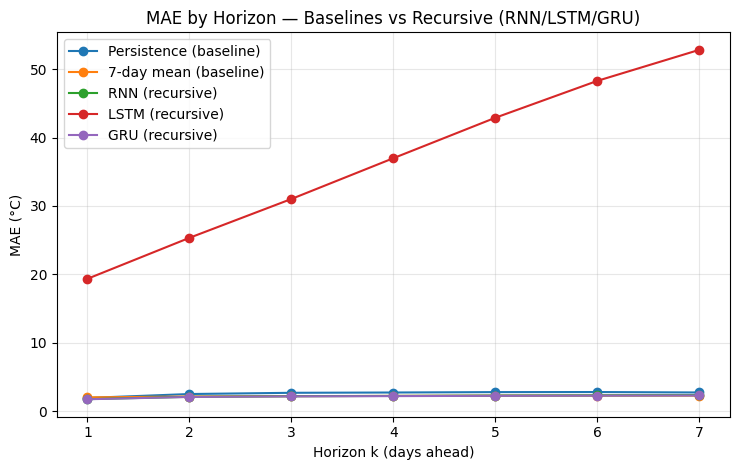

In [19]:
# --- Overlay MAE vs horizon: baselines vs recursive models ---
import matplotlib.pyplot as plt

def plot_mae_overlay():
    plt.figure(figsize=(7.5, 4.8))

    # Baselines (from Section 4): df_pers, df_mean7 should exist
    plt.plot(df_pers.loc[df_pers.index != "mean", "horizon_k"],
             df_pers.loc[df_pers.index != "mean", "MAE_C"],
             marker="o", label="Persistence (baseline)")
    plt.plot(df_mean7.loc[df_mean7.index != "mean", "horizon_k"],
             df_mean7.loc[df_mean7.index != "mean", "MAE_C"],
             marker="o", label="7-day mean (baseline)")

    # Recursive models
    plt.plot(df_rnn_rec.loc[df_rnn_rec.index != "mean", "horizon_k"],
             df_rnn_rec.loc[df_rnn_rec.index != "mean", "MAE_C"],
             marker="o", label="RNN (recursive)")
    plt.plot(df_lstm_rec.loc[df_lstm_rec.index != "mean", "horizon_k"],
             df_lstm_rec.loc[df_lstm_rec.index != "mean", "MAE_C"],
             marker="o", label="LSTM (recursive)")
    plt.plot(df_gru_rec.loc[df_gru_rec.index != "mean", "horizon_k"],
             df_gru_rec.loc[df_gru_rec.index != "mean", "MAE_C"],
             marker="o", label="GRU (recursive)")

    plt.xlabel("Horizon k (days ahead)")
    plt.ylabel("MAE (°C)")
    plt.title("MAE by Horizon — Baselines vs Recursive (RNN/LSTM/GRU)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_mae_overlay()


**Reading the plot.** We see what we’d expect: **persistence** is best for \(k=1\) but degrades fast; the **7-day mean** is steadier and becomes the yardstick for \(k\ge2\). Our **recursive RNN/GRU** sit close to those baselines, which is typical—once we feed our own predictions back in, small early errors **compound** and we get **phase lag** on peaks/troughs. The **LSTM line exploding** is not a model truth but a setup issue (likely weights not loaded or a **scaling mismatch**). We should confirm we loaded `lstm_state.pkl` and that rollout happens in **scaled space**, only inverse-transforming for metrics/plots.

**What we try next.** After fixing the LSTM setup, we expect its curve to drop into the 2–3 °C band like RNN/GRU. To beat the orange baseline for \(k\ge2\), we should reduce drift by trying a **Direct multi-output** head next, and/or give the model more context (**increase \(S\)**, add **day-of-year \(\sin/\cos\)**). Our target is: match persistence at \(k=1\) and **beat the 7-day mean** across most horizons.


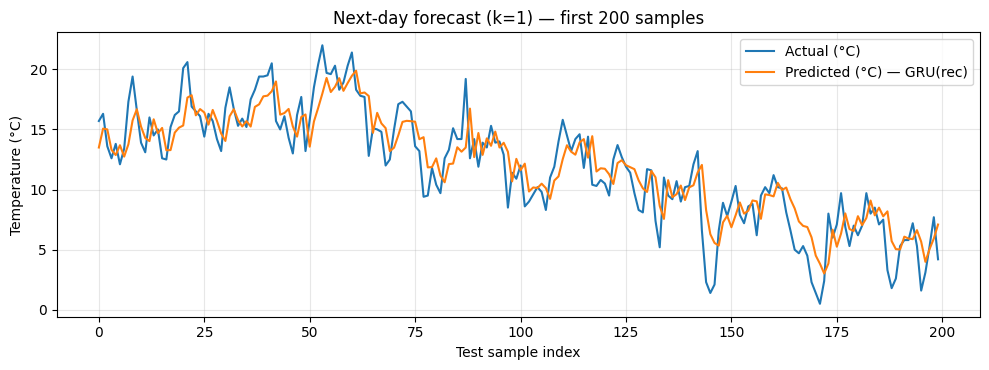

In [15]:
# --- One actual vs predicted slice (first 200 samples), horizon k=1 (next day) ---
SLICE = 200
k = 0  # horizon index 0 == k=1 day ahead

# pick the recursive model with the best mean RMSE
means = {
    "RNN(rec)":  df_rnn_rec.loc["mean", "RMSE_C"],
    "LSTM(rec)": df_lstm_rec.loc["mean", "RMSE_C"],
    "GRU(rec)":  df_gru_rec.loc["mean", "RMSE_C"],
}
best_name = min(means, key=means.get)

if best_name.startswith("RNN"):
    yhat_C = yC_rnn_rec[:, k]
elif best_name.startswith("LSTM"):
    yhat_C = yC_lstm_rec[:, k]
else:
    yhat_C = yC_gru_rec[:, k]

ytrue_C = yC_test[:, k]

plt.figure(figsize=(10, 3.8))
plt.plot(ytrue_C[:SLICE], label="Actual (°C)")
plt.plot(yhat_C[:SLICE],  label=f"Predicted (°C) — {best_name}")
plt.xlabel("Test sample index")
plt.ylabel("Temperature (°C)")
plt.title(f"Next-day forecast (k=1) — first {SLICE} samples")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
